# Projeto 12: Model Fitness

Esse projeto visa analisar os dados fornecidos pela rede de academias Model Fitness sobre o perfil de seus clientes, para montar uma estratégia de retenção de clientes.

Devemos:
- Aprender a predizer a probabilidade de rotatividade (para o mês seguinte) para cada cliente
- Elabore retratos de usuários típicos: selecione os grupos mais marcantes e descreva suas principais características
- Analise os fatores que mais impactam a rotatividade
- Tire conclusões básicas e desenvolva recomendações sobre como melhorar o serviço de clientes:
    - Identifique grupos alvo
    - Sugira medidas para diminuir a rotatividade
    - Descreva qualquer outro padrão que você vir com respeito às interações com clientes

## Dados

Importando bibliotecas e dados

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
gym_churn = pd.read_csv('/datasets/gym_churn_us.csv')

## Análise exploratória dos dados (AED)

Vamos olhar para a tabela e identificar se existem erros a serem corrigidos.

### Informações dos dados:

In [3]:
gym_churn.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Olhando para o dataframe "gym_churn" temos as seguintes informações:

- `gender`: Parece ser uma variável binária indicando o gênero do cliente (0 para feminino, 1 para masculino).
- `Near_Location`: Outra variável binária indicando se o cliente mora ou trabalha perto da academia.
- `Partner`: Variável binária indicando se o cliente é um funcionário de uma empresa parceira da academia.
- `Promo_friends`: Variável binária indicando se o cliente se inscreveu originalmente através de uma oferta "traga um amigo".
- `Phone`: Variável binária indicando se o cliente forneceu seu número de telefone.
- `Contract_period`: Parece ser uma variável discreta indicando o período do contrato do cliente (1 para 1 mês, 3 para 3 meses, 6 para 6 meses, 12 para 1 ano).
- `Group_visits`: Variável binária indicando se o cliente participa de sessões em grupo.
- `Age`: Idade do cliente.
- `Avg_additional_charges_total`: A quantidade total de dinheiro gasto em serviços adicionais da academia.
- `Month_to_end_contract`: Número de meses restantes no contrato do cliente.
- `Lifetime`: Tempo em meses desde a primeira visita do cliente à academia.
- `Avg_class_frequency_total`: A frequência média de visitas por semana durante toda a vida do cliente.
- `Avg_class_frequency_current_month`: A frequência média de visitas por semana durante o mês corrente.
- `Churn`: Variável binária indicando se o cliente cancelou sua assinatura no mês em questão (0 para não, 1 para sim).
Esta visualização inicial permite entender melhor a estrutura do conjunto de dados e as características disponíveis para análise.

Importante lembrar que a Model Fitness não forneceu legendas das variáveis binárias, então as atribuições dos valores foram adotadas da forma acima para que a análise pudesse ser realizada.

### Média de valores e desvio padrão

In [4]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Olhando com mais atenção para a coluna "Churn" é possivel ver que a média é 0,2652,  isso significa que, em média, cerca de 26,52% dos clientes cancelaram sua assinatura no mês em questão. Como a coluna "Churn" é uma variável binária (0 para não churn e 1 para churn), a média indica a proporção de clientes que cancelaram em relação ao total de clientes.

In [5]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [6]:
gym_churn.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

In [7]:
gym_churn.duplicated().sum()

0

Não foram encontrados valores nulos, duplicados e os dados estão no tipo adequado, então podemos continuar nossas análises.

### Média dos valores das características por agrupamentos:

Agrupar os dados por "Churn" e calcular a média dos valores médios para cada grupo:


In [8]:
mean_values_by_churn = gym_churn.groupby('Churn').mean()
mean_values_by_churn

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Para os clientes que ficaram (Churn=0):

- gender: Aproximadamente 51.00% são do gênero masculino.
- Near_Location: Cerca de 87.31% moram ou trabalham perto da academia.
- Partner: Cerca de 53.42% são funcionários de uma empresa parceira da academia.
- Promo_friends: Aproximadamente 35.35% se inscreveram originalmente através de uma oferta "traga um amigo".
- Phone: Cerca de 90.37% forneceram seu número de telefone.
- Contract_period: A média do período de contrato é de aproximadamente 5.75 meses.
- Group_visits: Cerca de 46.41% participam de sessões em grupo.
- Age: A idade média é de aproximadamente 29.98 anos.
- Avg_additional_charges_total: A média total de gastos adicionais é de aproximadamente 158.45 unidades monetárias.
- Month_to_end_contract: A média dos meses restantes no contrato é de aproximadamente 5.28 meses.
- Lifetime: O tempo médio desde a primeira visita é de aproximadamente 4.71 meses.
- Avg_class_frequency_total: A frequência média de visitas por semana durante toda a vida do cliente é de aproximadamente 2.02 vezes.
- Avg_class_frequency_current_month: A frequência média de visitas por semana durante o mês corrente é de aproximadamente 2.03 vezes.

Para os clientes que cancelaram (Churn=1):

- gender: Aproximadamente 51.08% são do gênero masculino.
- Near_Location: Cerca de 76.81% moram ou trabalham perto da academia.
- Partner: Cerca de 35.53% são funcionários de uma empresa parceira da academia.
- Promo_friends: Apenas cerca de 18.38% se inscreveram originalmente através de uma oferta "traga um amigo".
- Phone: Cerca de 90.29% forneceram seu número de telefone.
- Contract_period: A média do período de contrato é de aproximadamente 1.73 meses.
- Group_visits: Apenas cerca de 26.86% participam de sessões em grupo.
- Age: A idade média é de aproximadamente 26.99 anos.
- Avg_additional_charges_total: A média total de gastos adicionais é de aproximadamente 115.08 unidades monetárias.
- Month_to_end_contract: A média dos meses restantes no contrato é de aproximadamente 1.66 meses.
- Lifetime: O tempo médio desde a primeira visita é de aproximadamente 0.99 meses (1 mês).
- Avg_class_frequency_total: A frequência média de visitas por semana durante toda a vida do cliente é de aproximadamente 1.47 vezes.
- Avg_class_frequency_current_month: A frequência média de visitas por semana durante o mês corrente é de aproximadamente 1.04 vezes.

Essas médias fornecem insights sobre as diferenças nas características entre os clientes que cancelaram e os que permaneceram, o que pode ser útil para entender os fatores que influenciam a decisão de cancelamento da assinatura. Por exemplo, os clientes que cancelaram tendem a ter contratos mais curtos, menos participação em sessões em grupo e uma frequência de visita mais baixa em comparação com os clientes que permaneceram.

### Histograma

Vamos criar subplots para cada característica, exibindo os histogramas lado a lado para failitar a comparação.

In [9]:
sns.set(style="whitegrid")

# Lista de características para plotagem
features = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 
            'Contract_period', 'Group_visits', 'Age', 'Avg_additional_charges_total', 
            'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 
            'Avg_class_frequency_current_month']

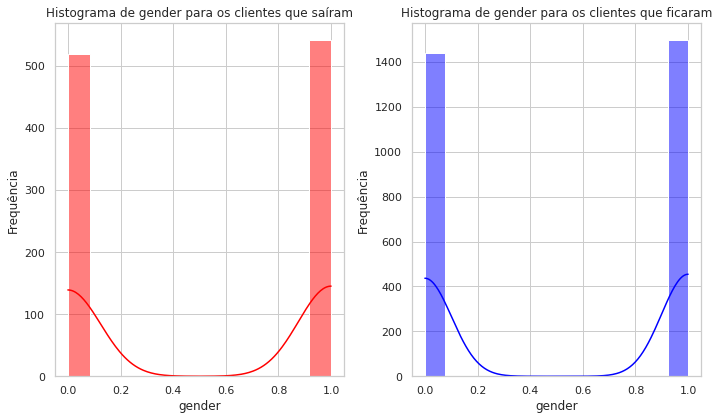

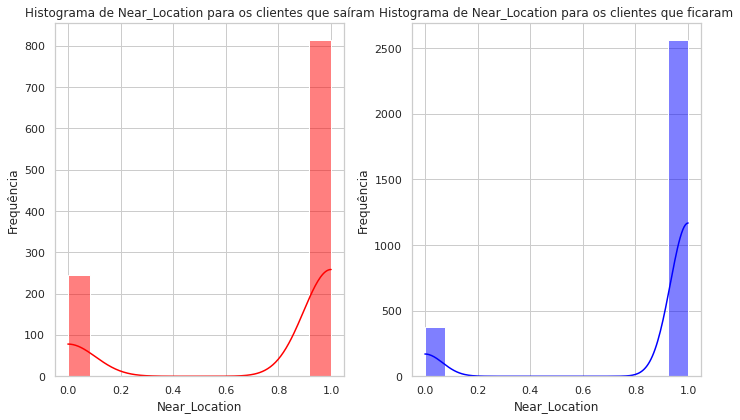

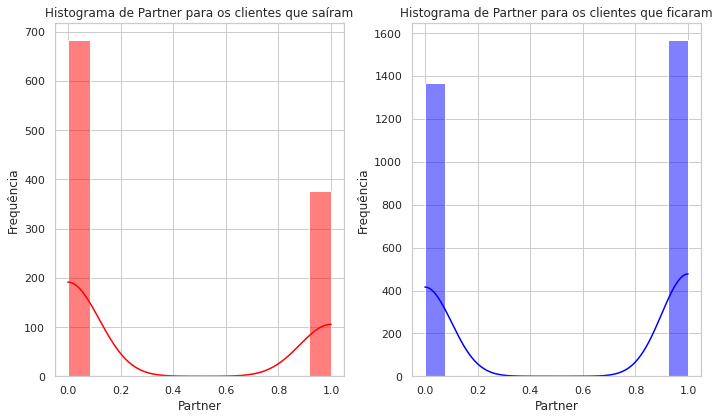

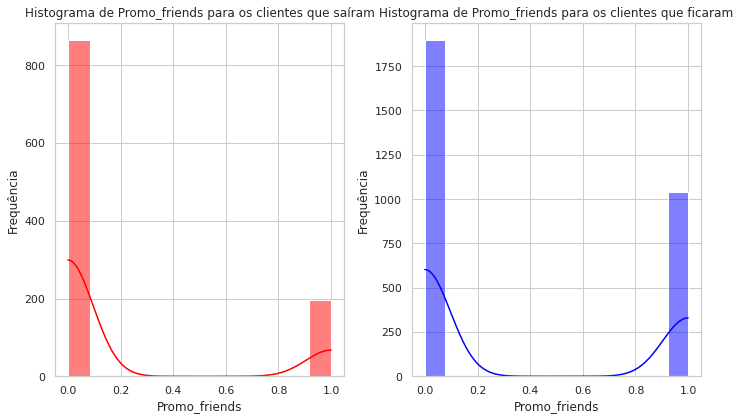

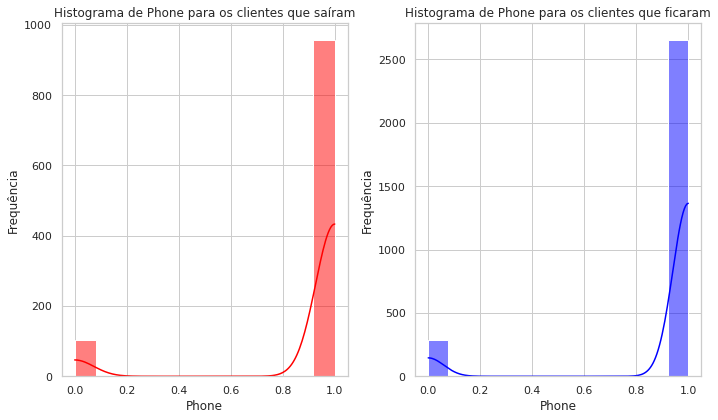

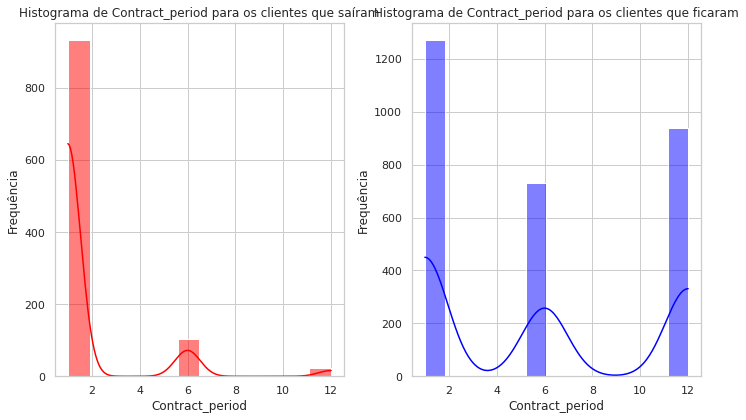

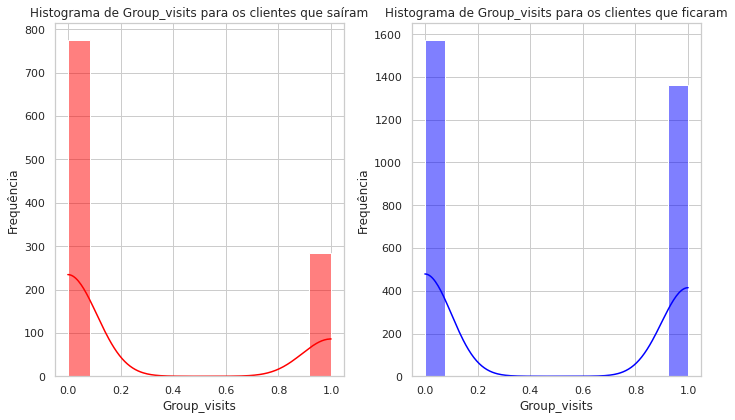

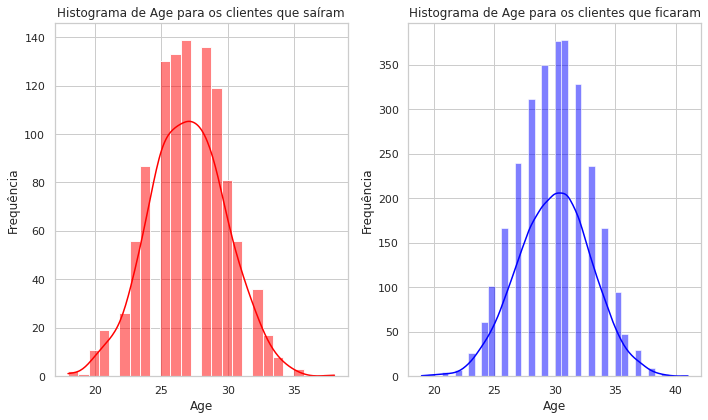

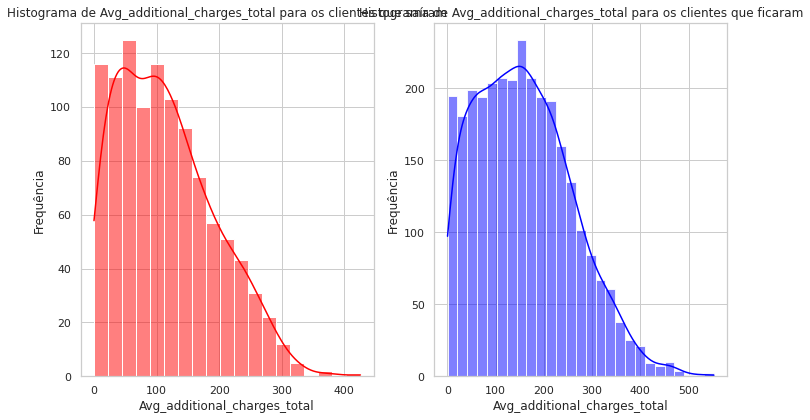

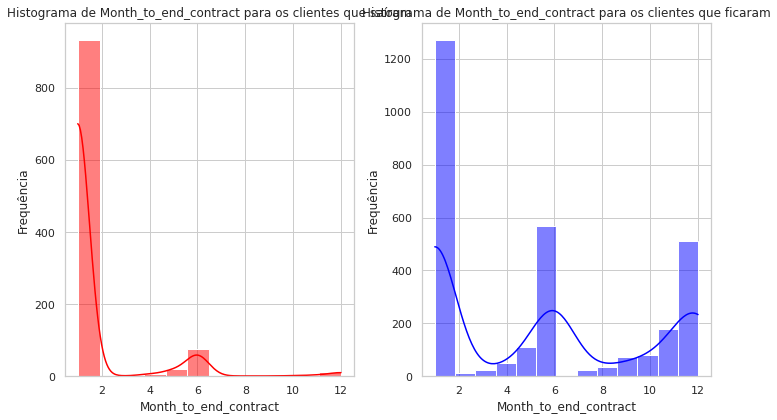

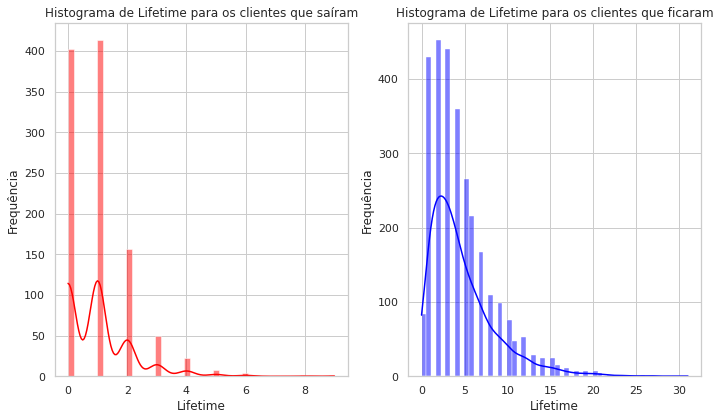

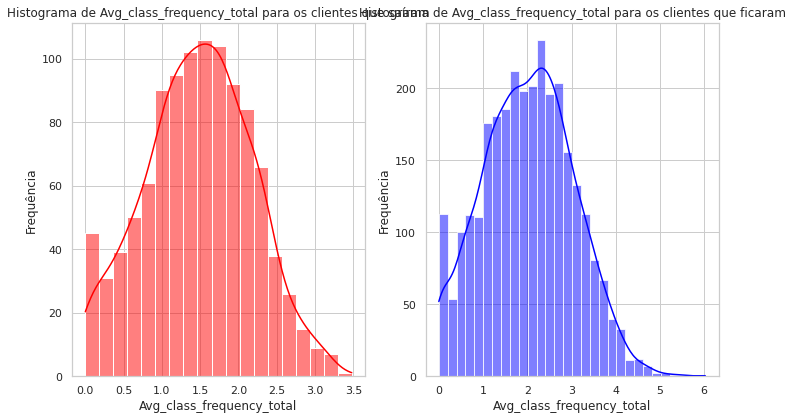

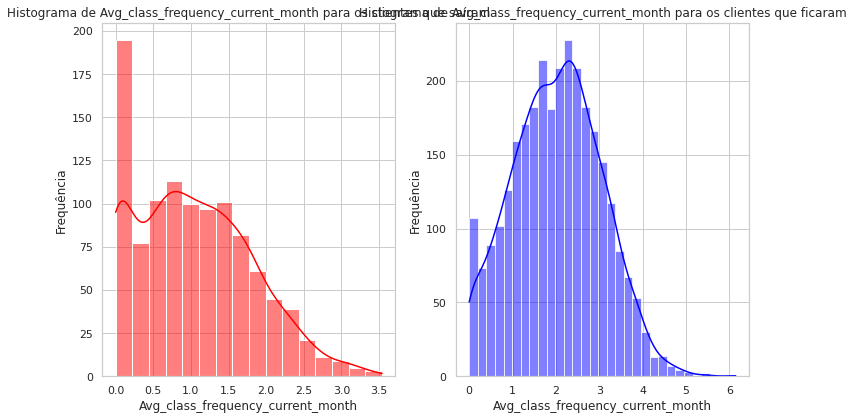

In [10]:
for feature in features:
    plt.figure(figsize=(10, 6))
    
    # Histograma para os clientes que saíram (Churn = 1)
    plt.subplot(1, 2, 1)
    sns.histplot(gym_churn[gym_churn['Churn'] == 1][feature], kde=True, color='red')
    plt.title(f'Histograma de {feature} para os clientes que saíram')
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    
    # Histograma para os clientes que ficaram (Churn = 0)
    plt.subplot(1, 2, 2)
    sns.histplot(gym_churn[gym_churn['Churn'] == 0][feature], kde=True, color='blue')
    plt.title(f'Histograma de {feature} para os clientes que ficaram')
    plt.xlabel(feature)
    plt.ylabel('Frequência')
    
    plt.tight_layout()
    plt.show()

### Matriz de correlação

Vamos calcular a matriz de correlação entre todas as características numéricas do conjunto de dados e, em seguida, plotar a matriz de correlação como um mapa de calor, onde os valores de correlação são representados por cores.

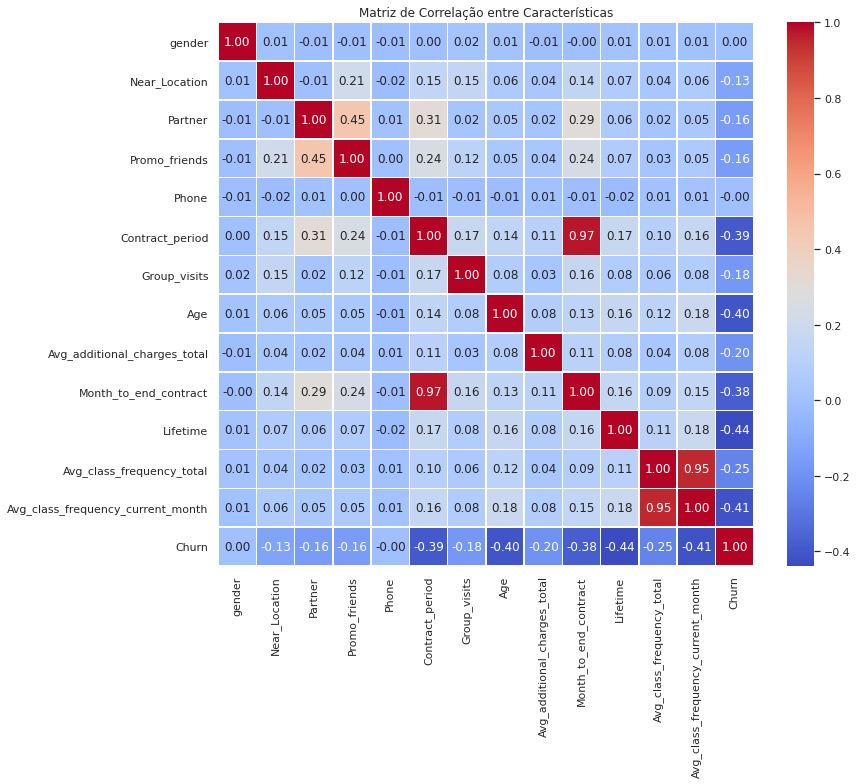

In [11]:
# Calcular a matriz de correlação
correlation_matrix = gym_churn.corr()

# Plotar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre Características')
plt.show()

Pela matriz de correlação é possível ver que alguns valores tem maior relação, como as colunas "Avg_class_frequency_total" e "Avg_class_frequency_current_month", essa relação pode ser pelo fato de que muitos alunos abandonam no primeiro mês, logo o frequência total é muito próxima da frequência do mês atual.

## Modelo para predizer a rotatividade de clientes

Para construir um modelo de classificação binária para prever a rotatividade de clientes, precisamos seguir os seguintes passos:

- Dividir os dados em conjuntos de treinamento e validação usando a função train_test_split() da biblioteca scikit-learn.
- Treinar o modelo usando regressão logística e floresta aleatória.
- Avaliar a acurácia, precisão e sensibilidade de ambos os modelos usando os dados de validação.
- Comparar os resultados dos dois modelos para determinar qual teve melhor desempenho.

In [16]:
# Dividir os dados em características (X) e rótulos (y)
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir os dados em conjuntos de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Treinar o modelo de regressão logística
logistic_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
logistic_model.fit(X_train, y_train)

# Prever os rótulos para os dados de validação
y_pred_logistic = logistic_model.predict(X_val)

# Calcular as métricas de desempenho para o modelo de regressão logística
accuracy_logistic = accuracy_score(y_val, y_pred_logistic)
precision_logistic = precision_score(y_val, y_pred_logistic)
recall_logistic = recall_score(y_val, y_pred_logistic)

# Treinar o modelo de floresta aleatória
random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train, y_train)

# Prever os rótulos para os dados de validação
y_pred_rf = random_forest_model.predict(X_val)

# Calcular as métricas de desempenho para o modelo de floresta aleatória
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf)
recall_rf = recall_score(y_val, y_pred_rf)

# Exibir os resultados
print("Regressão Logística:")
print("Acurácia:", accuracy_logistic)
print("Precisão:", precision_logistic)
print("Sensibilidade (Recall):", recall_logistic)
print("\nFloresta Aleatória:")
print("Acurácia:", accuracy_rf)
print("Precisão:", precision_rf)
print("Sensibilidade (Recall):", recall_rf)

Regressão Logística:
Acurácia: 0.915
Precisão: 0.8681318681318682
Sensibilidade (Recall): 0.7821782178217822

Floresta Aleatória:
Acurácia: 0.91
Precisão: 0.8494623655913979
Sensibilidade (Recall): 0.7821782178217822


<b>Acurácia:</b>

A acurácia é a proporção de previsões corretas do modelo em relação ao total de previsões feitas.
No caso da regressão logística, a acurácia é de aproximadamente 91,5%, o que significa que o modelo de regressão logística classifica corretamente cerca de 91,5% dos clientes como tendo permanecido ou saído.
Para a floresta aleatória, a acurácia é de cerca de 91,0%, indicando que o modelo de floresta aleatória classifica corretamente cerca de 91,0% dos clientes.

<b>Precisão:</b>

A precisão é a proporção de instâncias previstas como positivas (ou seja, saída de clientes) que são realmente positivas.
Para o modelo de regressão logística, a precisão é de aproximadamente 86,8%, o que significa que cerca de 86,8% dos clientes previstos como saídos realmente saíram.
Para o modelo de floresta aleatória, a precisão é de aproximadamente 84,9%, indicando que cerca de 84,9% dos clientes previstos como saídos realmente saíram.

<b>Sensibilidade (Recall):</b>

A sensibilidade, também conhecida como recall ou taxa de verdadeiros positivos, é a proporção de instâncias positivas reais que são corretamente previstas pelo modelo.
No caso da regressão logística e da floresta aleatória, a sensibilidade é a mesma, aproximadamente 78,2%. Isso indica que cerca de 78,2% dos clientes que realmente saíram foram corretamente identificados pelo modelo como saídos.

Em resumo, ambos os modelos têm um desempenho bastante similar em termos de acurácia, precisão e sensibilidade. Ambos conseguem prever corretamente a maioria das instâncias, mas a precisão da regressão logística é ligeiramente melhor do que a da floresta aleatória.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- Os modelos Regressão Logística e Random Forest foram utilizados
- As métricas de performance dos modelos foram calculadas
- As interpretações foram apresentadas
- A acurácia de pelo menos 0.78 foi alcançada

</div>

## Agrupamentos de clientes:

### Padronização dos dados e construção do dendrograma:

In [18]:
# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Construir a matriz de distâncias
linkage_matrix = linkage(X_scaled, method='ward')

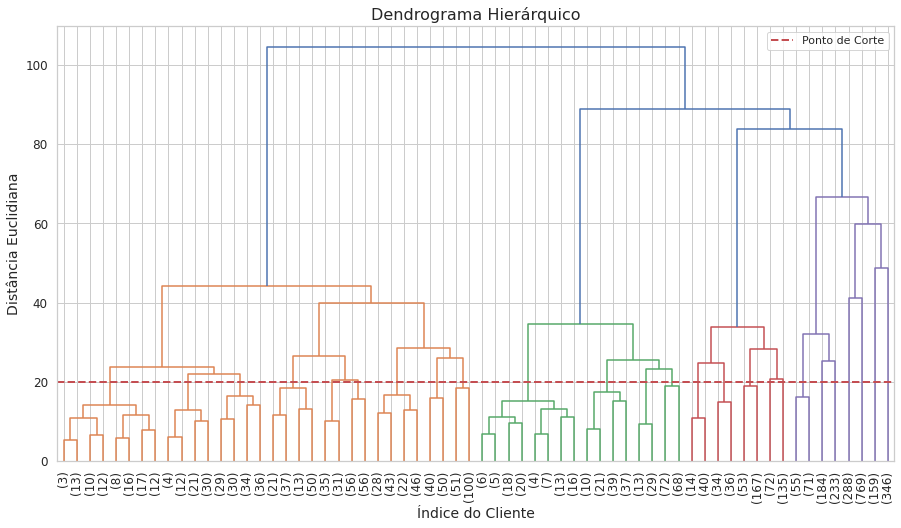

In [39]:
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title('Dendrograma Hierárquico', fontsize=16)
plt.xlabel('Índice do Cliente', fontsize=14)
plt.ylabel('Distância Euclidiana', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Destacar o ponto de corte
plt.axhline(y=20, color='r', linestyle='--', linewidth=2, label='Ponto de Corte')
plt.legend()
plt.show()

O dendrograma é uma representação gráfica de um agrupamento hierárquico, que mostra como os agrupamentos de dados são formados ao longo das etapas do processo de agrupamento. A distância entre os grupos continua pelo eixo Y e os objetos pelo eixo X. Cada link horizontal corresponde à distância entre os objetos que não tem nome. Se nos movermos de baixo para cima do gráfico, primeiro vamos ver que isso une objetos separados. Isso é seguido por links que unem objetos com grupos, ou grupos com grupos. Se você não parar esse processo intencionalmente, ele vai acabar quando um agrupamento gigante for deixado de fora.

O eixo vertical (Y) mostra a distância euclidiana entre os agrupamentos. A altura de cada linha no dendrograma representa a distância ou dissimilaridade entre os agrupamentos quando eles são fundidos. Quanto maior a distância no eixo Y, mais diferentes são os agrupamentos que estão sendo unidos.
A distância entre os cliente (3) e (13) é a menor de todas, embora existam outras distâncias com tamanhos semelhantes, isso indica que o comportamento desses clientes é muito parecido.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- Os dados foram padronizados
- O agrupamento hierárquico foi executado
- O dendograma foi criado
- A função `linkage()` foi utilizada para construir a matriz de distâncias
</div>

### Treinamento do modelo K-means e previsão de agrupamentos:

In [37]:
# Treinar o modelo K-means
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adicionar os agrupamentos aos dados originais
gym_churn['Cluster'] = clusters
gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,Cluster
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,2
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,2
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,0


Agora, cada linha do dataframe data possui um rótulo de cluster associado com base no modelo K-means treinado.

### Análise dos valores médios das características para os agrupamentos:

In [42]:
# Calcular os valores médios das características para cada agrupamento
cluster_means = gym_churn.groupby('Cluster').mean()
cluster_means

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
Cluster,,,,,,,,,,,,,,
0,0.502370,0.949447,0.829384,0.998420,1.0,3.097946,0.448657,29.104265,141.774331,2.887836,3.772512,1.770536,1.669581,0.246445
1,0.554556,0.849269,0.263217,0.052868,1.0,2.606299,0.436445,30.008999,159.774265,2.419573,4.780652,2.745505,2.733173,0.089989
2,0.499422,0.937572,0.737572,0.478613,1.0,11.854335,0.546821,29.905202,163.509804,10.812717,4.677457,2.006405,1.998179,0.021965
3,0.485738,0.718011,0.299919,0.018745,1.0,1.914425,0.276284,28.083945,129.496414,1.821516,2.195599,1.225192,0.967967,0.572942
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


Ao analisar a tabela com os valores médios das características para cada cluster, algumas observações podem chamar mais atenção:

<b>Participação em Programas Promocionais (Promo_friends):</b> O Cluster 0 (0.998) e o Cluster 2 (0.479) têm as maiores médias de participação em programas promocionais, indicando que a maioria dos clientes nesses clusters se inscreveram por meio de ofertas promocionais trazidas por amigos.

<b>Contratos de Longo Prazo (Contract_period):</b> O Cluster 2 se destaca com uma média muito alta de período de contrato (11.854), sugerindo que os clientes desse cluster tendem a preferir contratos de longo prazo.

<b>Participação em Grupos (Group_visits):</b> O Cluster 2 também apresenta a maior média de participação em sessões de grupo (0.547), indicando que esses clientes são mais propensos a participar de atividades em grupo na academia.

<b>Taxa de Churn (Churn):</b> O Cluster 2 (0.022) tem a menor taxa de churn, indicando uma maior fidelidade dos clientes nesse grupo em relação aos outros.

<b>Idade (Age):</b> Embora as diferenças não sejam tão marcantes, o Cluster 3 tem a menor média de idade (28.084), o que pode indicar uma predominância de clientes mais jovens nesse grupo.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

- O algoritmo `KMeans` foi utilizado para agrupar os usuários
- Os grupos gerados foram interpretados
</div>

### Distribuições de características para os agrupamentos:

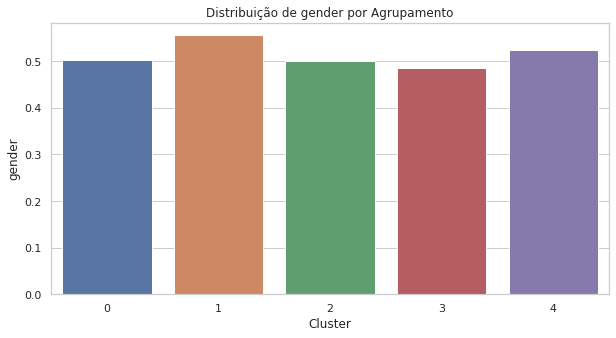

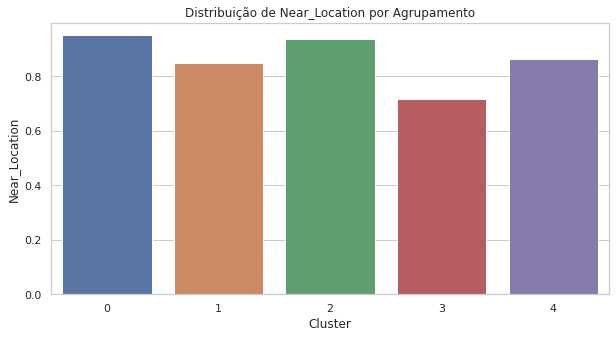

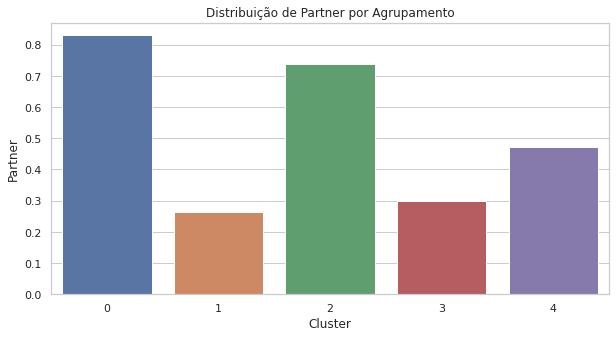

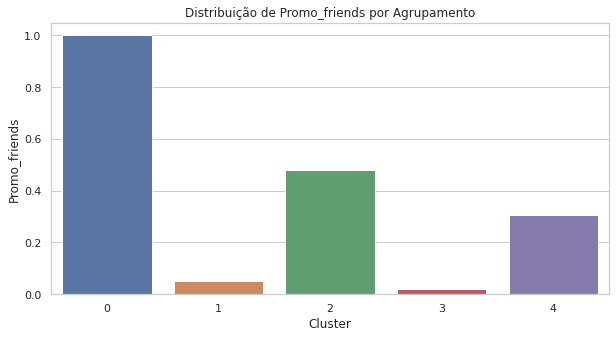

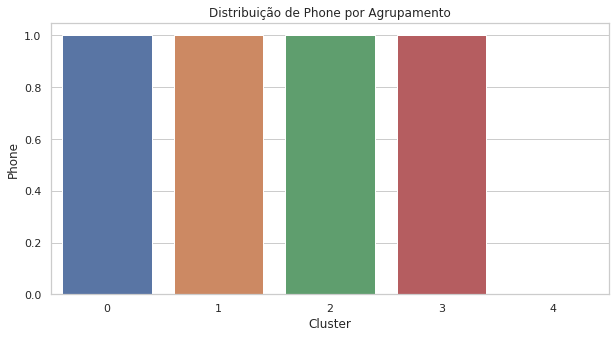

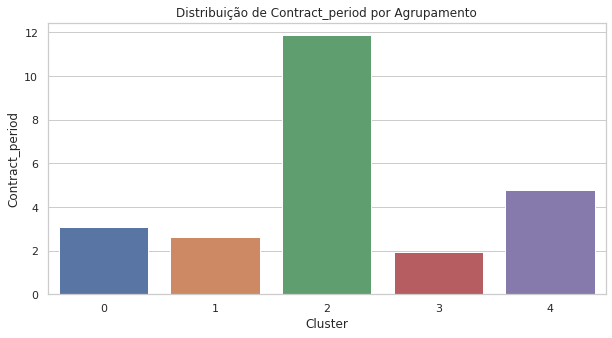

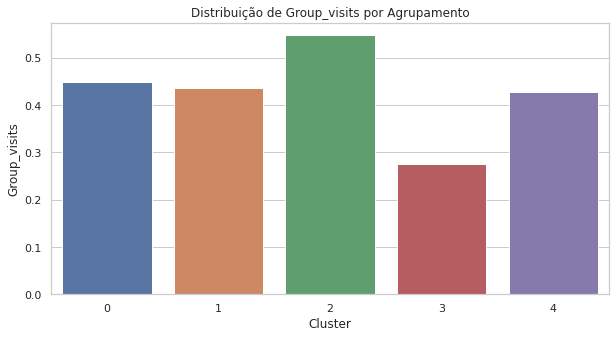

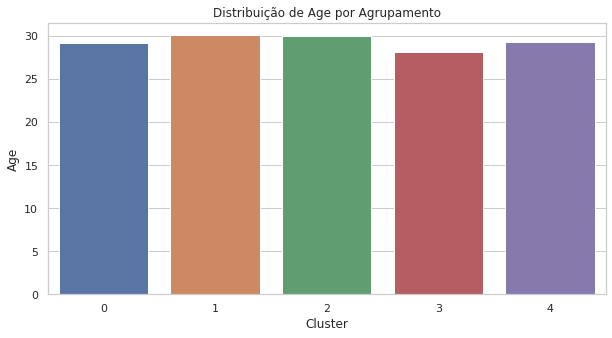

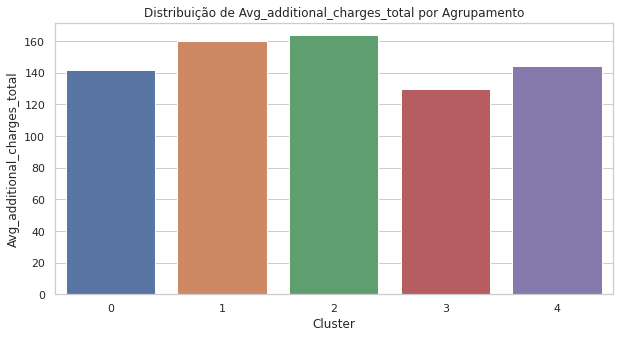

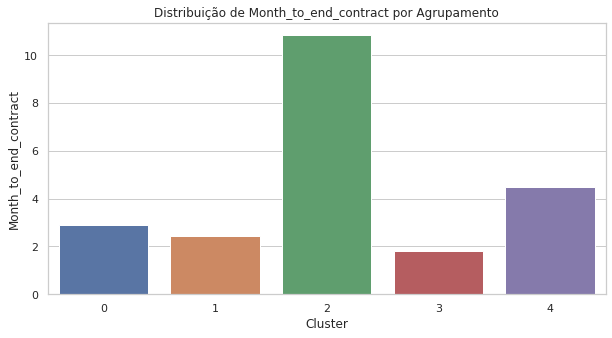

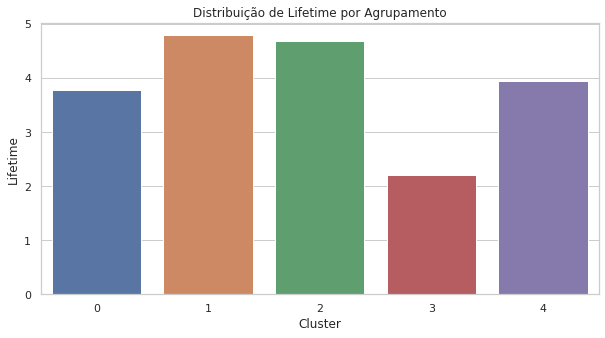

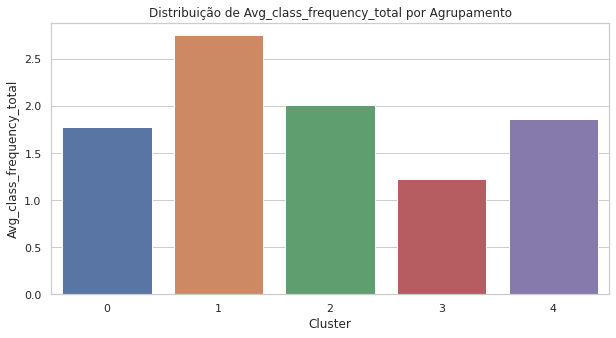

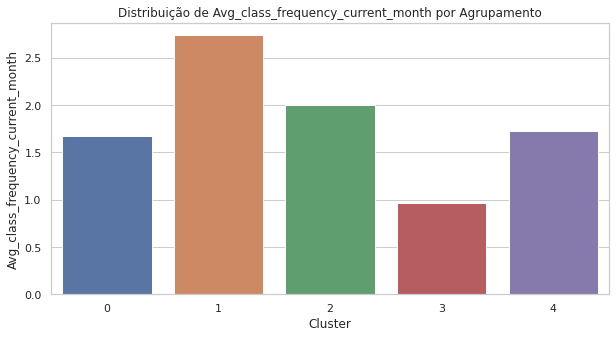

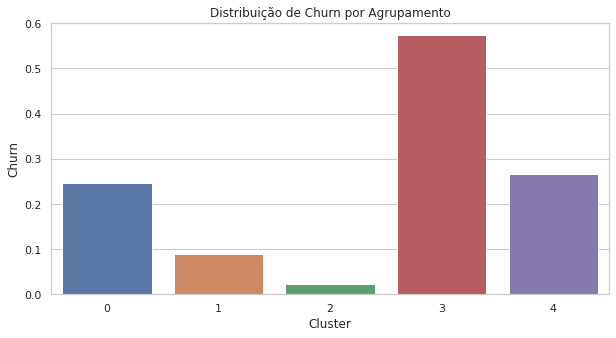

In [59]:
for column in gym_churn.columns[:-1]:  # Excluindo a coluna 'Churn' e 'Cluster'
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Cluster', y=column, data=gym_churn, ci=None)
    plt.title(f'Distribuição de {column} por Agrupamento')
    plt.show()

Na maioria das distribuições não há muita diferença entre os agrupamentos, mas na distribuição de Partner os agrupamentos 1 e 3 são menores, eles também são menores em Promo_friends, Contract_period e Month_to_end_contract.

A característica que tem maior diferença entre os agrupamentos é a Contract_period, isso demonstra que essa característica pode ser mais influente na distinção entre os diferentes tipos de clientes.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Excelente análise!
</div>

### Taxa de rotatividade para cada agrupamento:

In [60]:
# Calcular a taxa de rotatividade para cada agrupamento
churn_rate_by_cluster = gym_churn.groupby('Cluster')['Churn'].mean()

# Mostrar as taxas de rotatividade
print(churn_rate_by_cluster)

Cluster
0    0.246445
1    0.089989
2    0.021965
3    0.572942
4    0.266839
Name: Churn, dtype: float64


- Cluster 0: Apresenta uma taxa de rotatividade moderadamente alta.
- Cluster 1: Demonstra a menor taxa de rotatividade, indicando alta lealdade.
- Cluster 2: Tem a menor taxa de rotatividade entre todos os agrupamentos.
- Cluster 3: Apresenta uma taxa de rotatividade muito alta, sugerindo alta propensão para sair.
- Cluster 4: Apresenta uma taxa de rotatividade moderadamente alta.

Portanto, em termos de lealdade, os clientes do Cluster 2 são os mais leais, enquanto os do Cluster 3 são os menos leais, ou seja mais propensos a sair.

## Conclusões

Com base na análise dos dados e nas taxas de rotatividade por agrupamento, podemos tirar as seguintes conclusões e formular recomendações para a estratégia de interação e retenção de clientes:

- <b>Foco na Lealdade:</b> Priorize a retenção de clientes existentes, especialmente aqueles em agrupamentos com taxas de rotatividade mais altas. Investir na satisfação e fidelização desses clientes pode ser mais rentável do que atrair novos clientes.
Exemplo de Implementação: Ofereça programas de fidelidade, descontos exclusivos ou benefícios especiais para clientes que demonstram alta lealdade e engajamento com a academia.


- <b>Melhoria da Experiência do Cliente:</b> Concentre-se em melhorar a experiência geral do cliente, desde o momento em que entram na academia até o acompanhamento pós-treino. Clientes satisfeitos são mais propensos a permanecerem e recomendar a academia a outros.
Exemplo de Implementação: Implemente sistemas de feedback para coletar opiniões dos clientes e use essas informações para fazer melhorias contínuas nos serviços, instalações e programas oferecidos pela academia.


- <b>Comunicação Efetiva:</b> Mantenha uma comunicação regular e personalizada com os clientes, oferecendo suporte, incentivo e informações relevantes. Isso ajuda a construir relacionamentos sólidos e a manter os clientes engajados e informados.
Exemplo de Implementação: Envie newsletters regulares por e-mail com dicas de saúde, novidades da academia, eventos especiais e promoções exclusivas para clientes cadastrados.

Ao implementar esses princípios básicos de marketing e retenção de clientes, a academia pode melhorar a satisfação do cliente, aumentar a lealdade e reduzir a rotatividade, resultando em um negócio mais próspero e sustentável.

<div class="alert alert-block alert-success">
<b> Comentário do revisor: </b> <a class="tocSkip"></a>

Obrigado por enviar o seu projeto e pelo esforço de chegar até aqui. O seu projeto possui alguns pontos bem interessantes, dos quais eu destaco:
    
- Código bem simples e estruturado
- Comentários sucintos e bem objetivos
- Conclusões pertinentes em cada análise e etapa de avaliação
- Uso adequado de gráficos para os tipos de dados
    
    
Espero que você tenha uma jornada de muito aprendizado e te de desejo muito sucesso.
    
    
**Até breve!**

</div>

